# Equity Alpha Research Pipeline

This notebook demonstrates an end-to-end equity alpha research workflow on the
S&P 500 universe:

1. Load historical daily prices for the S&P 500 constituents.
2. Construct a set of cross-sectional, price-based factors.
3. Normalize factors cross-sectionally to make them comparable.
4. Build two signals:
   - A multi-factor composite signal (equal-weighted across z-scored factors).
   - A regression-based alpha (predicted returns) from a rolling
     cross-sectional model estimated out-of-sample.
5. Backtest both signals with transaction costs and compare performance.
6. Inspect information coefficient (IC) statistics for the alpha model.

## 1. Imports and environment setup

We import the project modules (data loader, factor library, alpha model, and backtester)
and configure basic display settings.

Note: we add the project root (`..`) to `sys.path` so the notebook can import from `src/`.

In [1]:
import sys
from pathlib import Path

# Ensure the project root is on the Python path so we can import from src/
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import EquityDataLoader, DataConfig
from src.factors import FactorCalculator, FactorConfig, zscore_cross_section
from src.alpha_model import (
    AlphaModel,
    AlphaModelOOS,
    AlphaModelOOSRidge,
    AlphaModelOOSRidgeEnsemble,
)
from src.backtester import Backtester
from src.optimizer import OptimizerConfig, PortfolioOptimizer

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', 50)

## 2. Define the equity universe and sample period

Earlier versions of this pipeline used a small universe of mega-cap technology
stocks to validate functionality. That is helpful for debugging but does not
produce realistic factor behaviour or stable cross-sectional regressions.

Here we expand the universe to the **full S&P 500 index**. This provides:

- a large, liquid cross-section suitable for daily factor modeling,
- more stable rolling estimates for momentum, volatility, and reversal factors,
- realistic information coefficients and Sharpe ratios, and
- a workflow aligned with professional systematic-equity research.

The S&P 500 constituent list is stored locally as `data/universe/sp500.csv`,
containing a `Symbol` column with ticker codes. The next cells load this
universe and define the multi-year sample window used throughout the analysis.

In [2]:
# Path to cached copy
sp500_path = ROOT / "data" / "universe" / "sp500.csv"
sp500_path.parent.mkdir(parents=True, exist_ok=True)

def load_sp500_tickers():
    """
    Load the S&P 500 constituent list from a local CSV file.

    Expected file: data/universe/sp500.csv
    Expected column: 'Symbol'
    """
    if not sp500_path.exists():
        raise FileNotFoundError(
            f"Expected {sp500_path} to exist.\n"
            "Please download an S&P 500 constituents CSV (with a 'Symbol' column) "
            "and save it to this path."
        )

    df = pd.read_csv(sp500_path)

    if "Symbol" not in df.columns:
        raise ValueError(
            f"sp500.csv must contain a 'Symbol' column. Columns found: {list(df.columns)}"
        )

    # Clean Yahoo Finance incompatible tickers (e.g., BRK.B → BRK-B)
    symbols = (
        df["Symbol"]
        .astype(str)
        .str.strip()
        .str.replace(".", "-", regex=False)
        .dropna()
        .unique()
        .tolist()
    )

    return symbols

sp500_tickers = load_sp500_tickers()
len(sp500_tickers), sp500_tickers[:10]

(503, ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A'])

In [3]:
universe = sp500_tickers
start = "2010-01-01"
end = "2024-12-31"

## 3. Load adjusted close prices

We use the `EquityDataLoader` to download and cache adjusted close prices from Yahoo Finance.

- Data is cached under `data/prices/raw/`.
- The result is a wide `DataFrame` with dates as the index and ticker symbols as columns.

In [4]:
data_cfg = DataConfig()
loader = EquityDataLoader(project_root=ROOT, config=data_cfg)

prices = loader.load_adjusted_close(
    tickers=universe,
    start=start,
    end=end,
    interval='1d',
    force_refresh=False,
)

prices.tail()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


[DataLoader] Skipping WBA: Downloaded empty DataFrame for ticker WBA.


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,...,WRB,GWW,WAB,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,126.589973,67.177307,112.184288,172.363205,353.719879,446.739990,124.599998,12.304317,100.531624,133.516983,286.256195,134.520004,96.599998,87.650490,93.018967,207.570007,131.106903,57.384167,189.902512,193.870728,195.229950,49.940449,225.059998,9.183184,87.134323,...,57.798267,1072.735474,190.486176,89.675789,110.926964,10.44,200.811218,369.760010,91.717125,69.039757,123.454231,328.502686,46.352802,27.177324,183.727386,52.675449,310.858765,265.390015,87.261322,65.543053,116.122368,131.317734,390.649994,105.818138,162.125519
2024-12-24,127.944412,67.500648,112.625923,173.918808,356.539642,447.940002,126.290001,12.266631,101.020866,135.004929,288.664795,134.990005,96.910004,88.426765,93.517395,213.500000,132.009857,57.732777,191.756134,195.344940,196.803833,49.837914,229.050003,9.241613,88.300125,...,58.095131,1081.298828,193.182526,91.988411,112.082031,10.55,202.368073,373.149994,91.910545,70.067413,124.407509,331.692291,46.458221,27.351536,184.919266,53.211460,312.490295,269.040009,87.924866,66.017303,116.754807,132.436081,395.440002,106.293640,162.539993
2024-12-26,128.749207,67.500648,113.126434,173.145828,355.356537,450.160004,125.059998,12.097046,101.431854,134.737091,287.748169,135.320007,97.959999,87.601364,93.705467,215.500000,131.960251,57.761826,191.854187,194.836945,196.335663,49.980442,227.050003,9.212399,88.105827,...,58.599792,1073.022949,192.884033,92.097588,112.072083,10.62,202.013336,376.779999,91.746147,70.233810,124.210960,332.350159,46.465744,27.264429,184.820770,52.587742,314.309692,269.380005,88.449760,65.988274,117.071037,133.417099,396.850006,106.244102,163.349258
2024-12-27,127.767731,67.049927,112.851646,171.996033,351.166321,446.480011,125.190002,12.012254,101.157860,134.449417,285.534576,133.384995,96.970001,86.756302,92.492310,211.429993,130.948135,57.655304,190.069244,192.008011,193.287506,49.771404,223.750000,9.192922,87.552071,...,58.352406,1059.494141,191.033401,90.976021,111.076332,10.61,201.028015,374.600006,91.697800,69.597633,122.844917,332.140839,45.705246,27.090216,183.264420,52.568245,312.767151,266.239990,87.825829,65.949562,116.142136,132.661728,389.070007,105.867676,162.441315
2024-12-30,126.737213,66.648193,110.702377,170.247192,347.528290,445.799988,122.440002,11.918040,100.756676,133.338425,281.516968,131.809998,95.559998,84.643646,91.975067,206.580002,129.955872,57.451954,188.843307,190.493942,191.942764,49.486343,221.300003,9.095539,87.066322,...,57.907120,1048.819580,189.988678,89.894157,110.329514,10.51,199.303680,370.940002,91.107872,68.912521,122.766312,327.755096,44.892040,26.993431,183.717514,52.782650,309.731537,262.000000,85.003288,65.417229,114.906891,130.984192,383.850006,104.646461,160.112274


### Quick price diagnostics

With a large universe (e.g. the full S&P 500), plotting every individual price series is not very informative and produces an unreadable legend. Instead, we:

- Plot a small sample of tickers as a visual sanity check.
- Plot the cross-sectional average price level over time as a simple aggregate view.

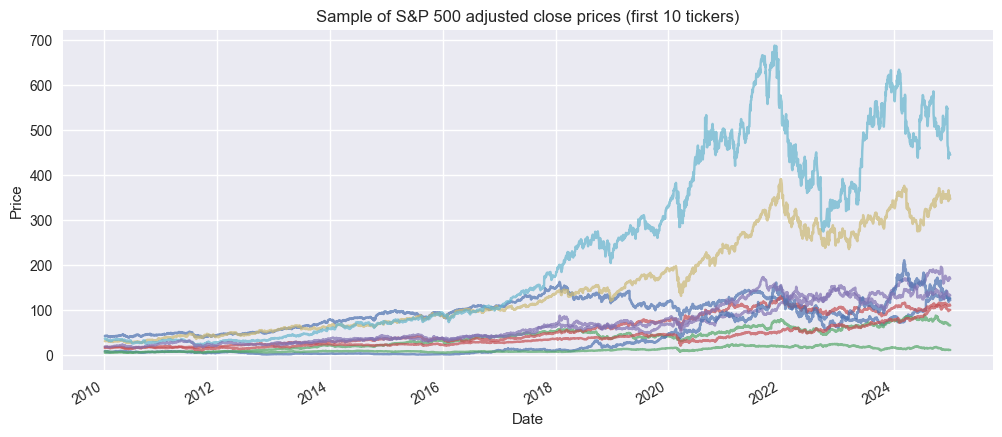

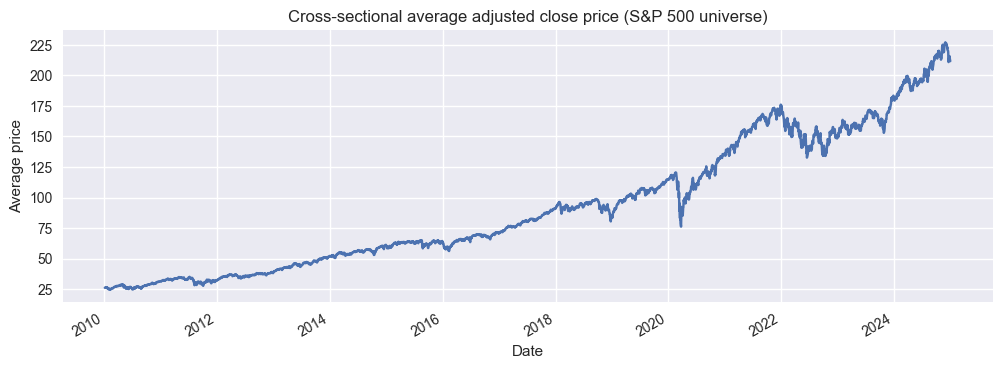

In [ ]:
# Plot a small sample of tickers (first 10 columns) without legend
sample_cols = prices.columns[:10]
prices[sample_cols].plot(
    figsize=(12, 5),
    alpha=0.7,
    legend=False,
    title="Sample of S&P 500 adjusted close prices (first 10 tickers)"
)
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Plot cross-sectional average price as an aggregate diagnostic
avg_price = prices.mean(axis=1)
avg_price.plot(
    figsize=(12, 4),
    title="Cross-sectional average adjusted close price (S&P 500 universe)"
)
plt.ylabel("Average price")
plt.grid(True)
plt.show()

## 4. Factor construction (expanded library)

We now build a richer library of purely price-based cross-sectional factors
from the daily adjusted close series. The current configuration includes:

- **ret_1d** – prior 1-day return (short-term reversal signal).
- **mom_21d, mom_63d, mom_252d** – approximately 1-month, 3-month, and
  12-month momentum, defined as cumulative returns over the respective windows.
- **vol_21d, vol_63d** – realized volatility of daily returns over
  1-month and 3-month windows.
- **rev_5d** – 5-day reversal, defined as the negative of the 5-day cumulative return.
- **vov_21x21d, vov_63x63d** – “volatility of volatility”: the rolling standard
  deviation of realized volatility itself, over 21- and 63-day windows.
- **volatility-scaled momentum** – ratios such as `mom_21d_over_vol_21d`,
  `mom_63d_over_vol_63d`, and `mom_252d_over_vol_63d`, which normalize momentum
  by recent volatility.

These factors are computed per stock and then standardized cross-sectionally
before being fed into the rolling out-of-sample alpha model.

In [6]:
factor_cfg = FactorConfig(
    ret_lag=1,
    momentum_windows=[21, 63, 252],
    volatility_windows=[21, 63],
    include_short_term_reversal=True,
    reversal_window=5,
    include_vol_of_vol=True,
    vov_windows=[21, 63],
    include_vol_adj_momentum=True,
    vol_adj_mom_pairs=[(21, 21), (63, 63), (252, 63)],
)

factor_calc = FactorCalculator(factor_cfg)
factor_panel = factor_calc.build_factor_panel(prices)

factor_panel.head()

ret_1d  mom_21d  mom_63d  mom_252d  vol_21d  vol_63d  \
date       ticker                                                           
2010-01-05 A      -0.010862      NaN      NaN       NaN      NaN      NaN   
           ABT    -0.008079      NaN      NaN       NaN      NaN      NaN   
           ACGL   -0.003336      NaN      NaN       NaN      NaN      NaN   
           ACN     0.006180      NaN      NaN       NaN      NaN      NaN   
           ADBE    0.016446      NaN      NaN       NaN      NaN      NaN   

                   rev_5d  vov_21x21d  vov_63x63d  mom_21d_over_vol_21d  \
date       ticker                                                         
2010-01-05 A          NaN         NaN         NaN                   NaN   
           ABT        NaN         NaN         NaN                   NaN   
           ACGL       NaN         NaN         NaN                   NaN   
           ACN        NaN         NaN         NaN                   NaN   
           ADBE       NaN         NaN         NaN                   NaN   

                   mom_63d_over_vol_63d  mom_252d_over_vol_63d  
date       ticker                                               
2010-01-05 A                        NaN                    NaN  
           ABT                      NaN                    NaN  
           ACGL                     NaN                    NaN  
           ACN                      NaN                    NaN  
           ADBE                     NaN                    NaN

## 5. Cross-sectional z-scoring of factors

On each date, we z-score factors across the cross-section of stocks. This
standardizes the scale of each factor and makes them comparable when we
combine them.

Missing factor values (for example, early in the sample before a rolling
window has fully warmed up) are preserved as `NaN`, so we do not introduce
artificial information where no data is available.

The result has the same `(date, ticker)` index but transformed values.

In [7]:
zpanel = zscore_cross_section(factor_panel)
zpanel.head()

ret_1d  mom_21d  mom_63d  mom_252d  vol_21d  vol_63d  \
date       ticker                                                           
2010-01-05 A      -0.764773      NaN      NaN       NaN      NaN      NaN   
           ABT    -0.617510      NaN      NaN       NaN      NaN      NaN   
           ACGL   -0.366528      NaN      NaN       NaN      NaN      NaN   
           ACN     0.136968      NaN      NaN       NaN      NaN      NaN   
           ADBE    0.680153      NaN      NaN       NaN      NaN      NaN   

                   rev_5d  vov_21x21d  vov_63x63d  mom_21d_over_vol_21d  \
date       ticker                                                         
2010-01-05 A          NaN         NaN         NaN                   NaN   
           ABT        NaN         NaN         NaN                   NaN   
           ACGL       NaN         NaN         NaN                   NaN   
           ACN        NaN         NaN         NaN                   NaN   
           ADBE       NaN         NaN         NaN                   NaN   

                   mom_63d_over_vol_63d  mom_252d_over_vol_63d  
date       ticker                                               
2010-01-05 A                        NaN                    NaN  
           ABT                      NaN                    NaN  
           ACGL                     NaN                    NaN  
           ACN                      NaN                    NaN  
           ADBE                     NaN                    NaN

## 6. Composite factor signal (Portfolio 1)

We construct a simple multi-factor composite by taking the cross-factor mean for each
`(date, ticker)` pair. This assumes equal weighting across all z-scored factors.

This composite will be used as the **signal** for Portfolio 1.

In [8]:
composite_signal = zpanel.mean(axis=1).rename('signal')
composite_signal.head()

date        ticker
2010-01-05  A        -0.764773
            ABT      -0.617510
            ACGL     -0.366528
            ACN       0.136968
            ADBE      0.680153
Name: signal, dtype: float64

## 7. Rolling Out-of-Sample Alpha Models: OLS vs Ridge Regression

In cross-sectional equity research, daily factor regressions suffer from
high noise, unstable coefficients, and strong multicollinearity between
factors (e.g., momentum and volatility families).  
Ordinary Least Squares (OLS) produces unbiased estimates, but is often
poorly conditioned, especially when the number of stocks varies day-to-day
or factor signals contain missing data.

Professional quant workflows therefore rely on **regularized regression**
methods that shrink coefficients to stabilize out-of-sample predictions.
The most common choice is **Ridge regression**, which adds an ℓ₂ penalty:

$$
\hat{\beta}
= \arg\min_{\beta} \, \| y - X\beta \|^2 \;+\; \lambda \|\beta\|^2 .
$$

where λ controls the strength of regularization.

We fit **both** models:

- **OLS OOS model**: Baseline, mirrors standard academic factor research  
- **Ridge OOS model**: More stable, more realistic for production alpha modeling  

Both models use:
- 60-day rolling training windows  
- Minimum 40 historical days  
- Minimum 50 stocks  
- 1-day forward returns as the prediction target

We estimate two rolling cross-sectional models:

**1. OLS (unregularized)**  
Used as a classical benchmark. Produces higher-variance coefficients and
often unstable out-of-sample predictions.

**2. Ridge (regularized)**  
Shrinks coefficients toward zero, improving stability and reducing noise.
This typically improves IC and lowers turnover.

The Ridge model uses `λ = 10`, though this can be tuned later through
cross-validated IC or by maximizing Sharpe in backtests.

In practice, cross-sectional factor regressions are noisy and ill-conditioned. Ridge regularization stabilizes coefficient estimates and reduces overfitting, which is especially important in large universes with correlated factors.

In [9]:
factor_columns = list(factor_panel.columns)

# OLS OOS model (baseline)
alpha_model_ols = AlphaModelOOS(
    factor_columns=factor_columns,
    lookback_days=60,
    min_history_days=40,
    min_stocks=50,
)
alpha_results_ols = alpha_model_ols.fit(zpanel, prices)
alpha_predictions_ols = alpha_results_ols["predictions"].rename("signal")

# Ridge OOS model (regularized)
alpha_model_ridge = AlphaModelOOSRidge(
    factor_columns=factor_columns,
    lookback_days=60,
    min_history_days=40,
    min_stocks=50,
    ridge_lambda=10.0,
)
alpha_results_ridge = alpha_model_ridge.fit(zpanel, prices)
alpha_predictions_ridge = alpha_results_ridge["predictions"].rename("signal")

alpha_predictions_ols.head(), alpha_predictions_ridge.head()

(date        ticker
 2011-01-10  A        -0.001854
             ABT       0.002773
             ACGL     -0.003384
             ACN      -0.001960
             ADBE      0.002295
 Name: signal, dtype: float64,
 date        ticker
 2011-01-04  A        -0.003342
             ABT       0.013637
             ACGL     -0.006874
             ACN      -0.003849
             ADBE     -0.003530
 Name: signal, dtype: float64)

### Choose the Alpha Model for Portfolio Construction

We keep both OLS and Ridge predictions available for diagnostics, but for
the remainder of the pipeline we select the **Ridge model** as our primary
alpha signal.

This mirrors common industry practice, where regularized models offer
more stable signals, higher IC, and smoother portfolio weights.

In [10]:
alpha_predictions = alpha_predictions_ridge
alpha_results = alpha_results_ridge

## 7b. Multi-horizon Ridge ensemble

Single-horizon linear models can miss structure in the data: some factors
work better over short windows, others over longer horizons, and the
“right” amount of regularization is itself uncertain.

A common quant trick is to build a small **ensemble** of related models and
average their predictions. Here we construct an ensemble of rolling
Ridge models with:

- Different lookback windows (short, medium, long).
- Different Ridge strengths (λ values).

On each date we:
1. Fit each member on its own rolling window of past data.
2. Collect its out-of-sample predictions.
3. Take the cross-member average prediction for each (date, ticker).

We then compare the ensemble’s information coefficient (IC) to the
single-horizon Ridge model.

In [11]:
# 7b.1 Fit a multi-horizon Ridge ensemble

ensemble_lookbacks = [20, 60, 126]      # ~1m, 3m, 6m
ensemble_lambdas = [5.0, 10.0, 20.0]    # increasing regularization

alpha_model_ens = AlphaModelOOSRidgeEnsemble(
    factor_columns=factor_columns,
    lookbacks=ensemble_lookbacks,
    lambdas=ensemble_lambdas,
    min_history_days=40,
    min_stocks=50,
)

alpha_results_ens = alpha_model_ens.fit(zpanel, prices)
alpha_predictions_ens = alpha_results_ens["predictions"].rename("signal")

alpha_results_ens["predictions"].head()

2011-01-04  A      -0.003431
            ABT     0.013059
            ACGL   -0.006231
            ACN    -0.003845
            ADBE   -0.003361
Name: prediction, dtype: float64

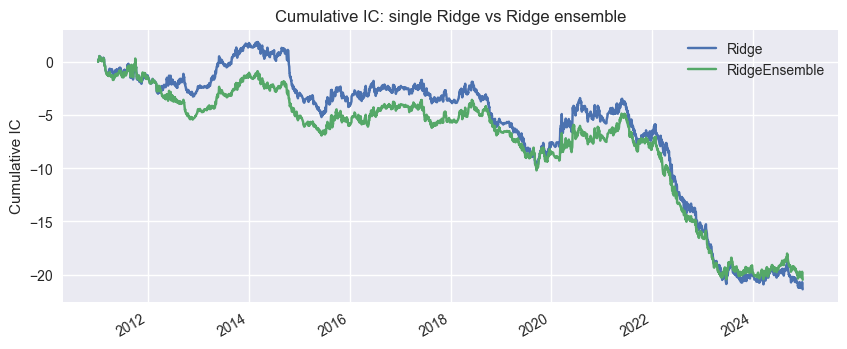

,MeanIC,ICtStat
Ridge,-0.006776,-2.231430
RidgeEnsemble,-0.004167,-1.589191


In [12]:
# 7b.2 Compare IC: single Ridge vs Ridge ensemble

# Single Ridge IC
ic_ridge = alpha_results_ridge["ic"]
if isinstance(ic_ridge, pd.DataFrame):
    ic_ridge = ic_ridge["ic"].dropna()
else:
    ic_ridge = ic_ridge.dropna()
ic_ridge.name = "Ridge"

# Ensemble IC (equal-weight average of members)
ic_ens = alpha_results_ens["ic_ensemble"].dropna()
ic_ens.name = "RidgeEnsemble"

ic_compare = pd.concat([ic_ridge, ic_ens], axis=1, join="inner").dropna()

# Plot cumulative IC
ic_compare.cumsum().plot(figsize=(10, 4))
plt.title("Cumulative IC: single Ridge vs Ridge ensemble")
plt.ylabel("Cumulative IC")
plt.grid(True)
plt.show()

# Summary: mean IC and IC t-stat for each
def ic_summary(series: pd.Series) -> pd.Series:
    s = series.dropna()
    mu = s.mean()
    sigma = s.std()
    tstat = mu / sigma * np.sqrt(len(s)) if sigma > 0 else np.nan
    return pd.Series({"MeanIC": mu, "ICtStat": tstat})

summary_ridge = ic_summary(ic_ridge)
summary_ens = ic_summary(ic_ens)

pd.DataFrame([summary_ridge, summary_ens], index=["Ridge", "RidgeEnsemble"])

## 8. Daily dollar-neutralization of signals

The raw composite signal and the regression-based alpha can have arbitrary
net exposure on each date (for example, more positive than negative names
on a given day). Real long–short equity portfolios are usually constructed
with explicit neutrality constraints, such as:

- **Dollar-neutrality**: total long weight equals total short weight,
  so net exposure is 0.
- **Unit gross exposure**: the sum of absolute weights is 1, which
  stabilizes risk.

Before passing signals into the backtester, we transform them into
daily dollar-neutral portfolios with unit gross exposure by:

1. Subtracting the cross-sectional mean of the signal each day
   (to remove net exposure).
2. Scaling the residuals so that the sum of absolute weights is 1.

The next cell implements this transformation as
`dollar_neutralize_signal(...)`.

In [ ]:
def dollar_neutralize_signal(signal: pd.Series) -> pd.Series:
    """
    Make a (date, ticker) signal dollar-neutral with unit gross exposure per date.

    Parameters
    ----------
    signal : Series
        MultiIndex (date, ticker).

    Returns
    -------
    Series
        Same index, but for each date t:
          - sum of weights is 0 (dollar-neutral),
          - sum of absolute weights is 1 (unit gross exposure),
          - NaNs are handled gracefully.
    """
    if not isinstance(signal.index, pd.MultiIndex):
        raise TypeError("signal index must be a MultiIndex (date, ticker).")

    if signal.index.names != ["date", "ticker"]:
        signal = signal.copy()
        signal.index.set_names(["date", "ticker"], inplace=True)

    def _neutralize(group: pd.Series) -> pd.Series:
        g = group.astype(float).replace([np.inf, -np.inf], np.nan)

        if g.isna().all():
            return g.fillna(0.0)
        g = g - g.mean(skipna=True)
        gross = g.abs().sum(skipna=True)
        if not np.isfinite(gross) or gross == 0.0:
            return g * 0.0

        return g / gross

    return signal.groupby(level="date", group_keys=False).apply(_neutralize)

In [14]:
composite_signal_neutral = dollar_neutralize_signal(composite_signal)
alpha_signal_neutral = dollar_neutralize_signal(alpha_predictions)

## 9. Sector data for risk-neutral portfolios

To avoid the alpha model simply tilting into sectors (for example, being
structurally overweight Technology or underweight Utilities), we add a
sector-neutrality step. We load a mapping from each S&P 500 ticker to a
sector label from `data/universe/sp500.csv`, then use it to construct
sector-neutral portfolio weights.

In [15]:
# Load ticker -> sector mapping from the same CSV used for the universe
sp500_meta = pd.read_csv(ROOT / "data" / "universe" / "sp500.csv")

# Try to find a sector column
sector_col_candidates = ["Sector", "GICS Sector"]
sector_col = None
for c in sector_col_candidates:
    if c in sp500_meta.columns:
        sector_col = c
        break

if sector_col is None:
    raise ValueError(
        "sp500.csv must contain a 'Sector' or 'GICS Sector' column for sector-neutrality.\n"
        f"Columns found: {list(sp500_meta.columns)}"
    )

# Clean tickers and build sector map
sp500_meta["Symbol"] = (
    sp500_meta["Symbol"]
    .astype(str)
    .str.strip()
    .str.replace(".", "-", regex=False)
)

sector_map = (
    sp500_meta
    .set_index("Symbol")[sector_col]
    .astype(str)
    .str.strip()
)

sector_map.head()

Symbol
MMM                Industrials
AOS                Industrials
ABT                Health Care
ABBV               Health Care
ACN     Information Technology
Name: GICS Sector, dtype: object

## 10. Market- and sector-neutral portfolio weights

Dollar-neutrality alone enforces zero net exposure, but the portfolio can
still carry large sector tilts (for example, systematically long Technology
and short Utilities). To isolate stock-selection alpha, we further
neutralize signals with respect to:

- a **market factor** (a column of ones), and
- **sector dummy variables** built from the ticker → sector map.

For each date, we project the raw signal into the orthogonal complement of
these exposures and then rescale the result to unit gross exposure. The
resulting portfolio is both market-neutral and sector-neutral.

In [16]:
def neutralize_market_and_sector(
    signal: pd.Series,
    sector_map: pd.Series,
) -> pd.Series:
    """
    For each date, neutralize a (date, ticker) signal with respect to:
      - market (a column of ones)
      - sector dummies (from sector_map)

    Then rescale so that the sum of absolute weights is 1 (unit gross exposure).

    Parameters
    ----------
    signal : Series
        MultiIndex (date, ticker).
    sector_map : Series
        Index: ticker, values: sector labels (string).

    Returns
    -------
    Series
        Same MultiIndex, market- and sector-neutral with unit gross exposure per date.
    """
    if not isinstance(signal.index, pd.MultiIndex):
        raise TypeError("signal index must be a MultiIndex (date, ticker).")

    sig = signal.copy()
    if sig.index.names != ["date", "ticker"]:
        sig.index.set_names(["date", "ticker"], inplace=True)

    def _neutralize(group: pd.Series) -> pd.Series:
        # group index: (date, ticker) for a single date
        s = group.astype(float).replace([np.inf, -np.inf], np.nan)
        tickers = group.index.get_level_values("ticker")

        # Valid (non-NaN) entries
        mask_valid = s.notna()
        if mask_valid.sum() < 2:
            # Too few names to define a cross-section
            return pd.Series(0.0, index=group.index)

        # Restrict to valid subset
        s_valid = s[mask_valid]
        tickers_valid = tickers[mask_valid.to_numpy()]

        # Map sectors for valid tickers; missing sectors -> 'Unknown'
        sec_valid = sector_map.reindex(tickers_valid).fillna("Unknown")

        # Build exposure matrix E: [market, sector_1, sector_2, ...]
        sectors = pd.Categorical(sec_valid)
        n = len(s_valid)
        k = len(sectors.categories) + 1  # +1 for market column

        E = np.zeros((n, k), dtype=float)
        # Market column
        E[:, 0] = 1.0
        # Sector dummies
        for j, cat in enumerate(sectors.categories, start=1):
            mask = (sectors == cat)            # boolean array
            E[:, j] = mask.astype(float)       # no .values here

        y = s_valid.to_numpy()

        # Solve projection: neutralize w.r.t. columns of E
        XtX = E.T @ E
        XtX_inv = np.linalg.pinv(XtX)
        beta = XtX_inv @ (E.T @ y)
        y_neutral = y - E @ beta

        # Build weights series on valid subset
        w = pd.Series(y_neutral, index=s_valid.index)

        # Rescale to unit gross exposure
        gross = w.abs().sum()
        if not np.isfinite(gross) or gross == 0.0:
            w[:] = 0.0
        else:
            w = w / gross

        # Embed back into full group index (fill missing with 0)
        out = pd.Series(0.0, index=group.index)
        out.loc[w.index] = w
        return out

    return sig.groupby(level="date", group_keys=False).apply(_neutralize)

In [17]:
composite_signal_mkt_sec = neutralize_market_and_sector(composite_signal, sector_map)
alpha_signal_mkt_sec = neutralize_market_and_sector(alpha_predictions, sector_map)

net_comp = composite_signal_mkt_sec.groupby(level="date").sum()
gross_comp = composite_signal_mkt_sec.groupby(level="date").apply(lambda x: x.abs().sum())

net_alpha = alpha_signal_mkt_sec.groupby(level="date").sum()
gross_alpha = alpha_signal_mkt_sec.groupby(level="date").apply(lambda x: x.abs().sum())

net_comp.describe(), gross_comp.describe(), net_alpha.describe(), gross_alpha.describe()

(count    3.772000e+03
 mean     2.192122e-15
 std      2.598333e-15
 min     -8.613336e-15
 25%      1.682140e-16
 50%      2.080259e-15
 75%      4.118179e-15
 max      1.072536e-14
 Name: signal, dtype: float64,
 count    3.772000e+03
 mean     1.000000e+00
 std      1.034004e-16
 min      1.000000e+00
 25%      1.000000e+00
 50%      1.000000e+00
 75%      1.000000e+00
 max      1.000000e+00
 Name: signal, dtype: float64,
 count    3.155000e+03
 mean     5.845307e-16
 std      3.099072e-15
 min     -1.133772e-14
 25%     -1.285593e-15
 50%      3.909633e-16
 75%      2.569505e-15
 max      1.442726e-14
 Name: signal, dtype: float64,
 count    3.155000e+03
 mean     1.000000e+00
 std      9.370892e-17
 min      1.000000e+00
 25%      1.000000e+00
 50%      1.000000e+00
 75%      1.000000e+00
 max      1.000000e+00
 Name: signal, dtype: float64)

## 11. PCA risk model and risk-neutral signals

Even after enforcing market and sector neutrality, our signals can still
carry unintended exposure to other systematic risk directions embedded in
the cross-section of stock returns. A common way to summarize these risk
directions is through a **PCA risk model**.

The idea:

- Use a rolling window of past returns to estimate the cross-sectional
  covariance matrix.
- Extract the top few eigenvectors (principal components). These define
  **risk factors** (for example, growth vs value, low vs high volatility).
- Each stock has an **exposure** (loading) to each PCA factor.
- We then **project our alpha signal onto these risk factors and remove
  that projection**, leaving a residual signal that is orthogonal to the
  risk model.

This is what practitioners mean by “neutralizing a signal against the
risk model”. Below, we build a simple PCA risk model with a 252-day
rolling window and the top 5 principal components.

PCA neutralization removes exposure to latent common risk factors (e.g. market-like or sector-like modes) without relying on an explicit fundamental risk model.

In [18]:
# 11.1 Build a rolling PCA risk model from daily returns

# Daily simple returns
returns = prices.pct_change().dropna(how="all")

window = 252          # ~1 year of trading days
n_components = 5      # number of PCA risk factors


def compute_pca_exposures(
    returns: pd.DataFrame,
    window: int = 252,
    n_components: int = 5,
) -> pd.DataFrame:
    """
    Compute rolling PCA exposures (loadings) for each stock.

    For each date t, we look back `window` days of returns, build the
    covariance matrix, extract the top `n_components` eigenvectors,
    and treat them as risk-factor exposures for that date.

    Returns
    -------
    DataFrame
        MultiIndex (date, ticker), columns = ['pc1', ..., 'pcK'].
    """
    dates = list(returns.index)
    exposures_list = []

    for i in range(window, len(dates)):
        end_date = dates[i]
        window_dates = dates[i - window : i]

        R = returns.loc[window_dates]

        # Drop tickers with too many missing values in the window
        min_non_na = int(window * 0.8)
        R = R.dropna(axis=1, thresh=min_non_na)

        # Need enough names to define a PCA
        if R.shape[1] <= n_components:
            continue

        # Fill remaining NaNs with column means, then demean
        R = R.fillna(R.mean())
        R = R - R.mean()

        # Covariance of stocks (columns = tickers)
        cov = np.cov(R.T)

        # Eigen decomposition (ascending by default)
        vals, vecs = np.linalg.eigh(cov)

        # Take eigenvectors for largest eigenvalues
        idx = np.argsort(vals)[::-1]
        vecs = vecs[:, idx[:n_components]]  # shape: n_stocks x K

        tickers_window = R.columns
        cols = [f"pc{k+1}" for k in range(n_components)]

        expo_t = pd.DataFrame(vecs, index=tickers_window, columns=cols)
        expo_t["date"] = end_date
        expo_t = expo_t.reset_index().rename(columns={"index": "ticker"})

        exposures_list.append(expo_t)

    if not exposures_list:
        cols = [f"pc{k+1}" for k in range(n_components)]
        return (
            pd.DataFrame(columns=["date", "ticker"] + cols)
            .set_index(["date", "ticker"])
        )

    exposures = pd.concat(exposures_list, ignore_index=True)
    exposures = exposures.set_index(["date", "ticker"]).sort_index()

    return exposures


pca_exposures = compute_pca_exposures(returns, window=window, n_components=n_components)
pca_exposures.head()

pc1       pc2       pc3       pc4       pc5
date       ticker                                                  
2011-01-04 A      -0.058734 -0.040090 -0.026512 -0.034227 -0.043446
           ABT    -0.020682  0.007269 -0.049706  0.015438 -0.017789
           ACGL   -0.025818  0.016813 -0.014060 -0.008892 -0.023281
           ACN    -0.031994  0.002577 -0.023895 -0.000077 -0.038374
           ADBE   -0.045560 -0.003787 -0.019636 -0.063897 -0.035896

In [19]:
# 11.2 Variance explained by the top PCA factors (recent window diagnostic)

recent_window = returns.iloc[-window:]
R = recent_window.dropna(axis=1, thresh=int(window * 0.8))
R = R.fillna(R.mean())
R = R - R.mean()

cov_recent = np.cov(R.T)
vals_recent, _ = np.linalg.eigh(cov_recent)
vals_sorted = np.sort(vals_recent)[::-1]
explained = vals_sorted / vals_sorted.sum()

explained_series = pd.Series(
    explained[:10],
    index=[f"pc{k+1}" for k in range(10)],
    name="explained_variance_ratio",
)
explained_series.to_frame()

,explained_variance_ratio
pc1,0.199223
pc2,0.071392
pc3,0.042602
pc4,0.027893
pc5,0.023964
pc6,0.022671
pc7,0.019545
pc8,0.016029
pc9,0.015449
pc10,0.014510


In [20]:
# 11.3 Neutralize a signal against PCA risk factors (fixed mask logic)

def neutralize_pca_risk(
    signal: pd.Series,
    exposures: pd.DataFrame,
    n_components: int = 5,
) -> pd.Series:
    """
    Neutralize a (date, ticker) signal against PCA risk factors.

    For each date t, we:
      - Align the signal with the PCA exposures for that date.
      - Project the signal onto the span of the PCA factors.
      - Subtract that projection to get a residual signal.
      - Recentre and rescale to unit gross exposure.

    If the risk model is unavailable or ill-conditioned for a date,
    we fall back to simple dollar-neutralization.
    """
    if not isinstance(signal.index, pd.MultiIndex):
        raise TypeError("signal index must be a MultiIndex (date, ticker).")

    if signal.index.names != ["date", "ticker"]:
        signal = signal.copy()
        signal.index.set_names(["date", "ticker"], inplace=True)

    if exposures.index.names != ["date", "ticker"]:
        exposures = exposures.copy()
        exposures.index.set_names(["date", "ticker"], inplace=True)

    cols = [f"pc{k+1}" for k in range(n_components)]

    def _neutralize(group: pd.Series) -> pd.Series:
        # All rows in this group share the same date
        date = group.index.get_level_values("date")[0]

        # PCA exposures for this date
        try:
            expo_day = exposures.xs(date, level="date")[cols]
        except KeyError:
            # No risk model for this date
            return dollar_neutralize_signal(group)

        # Cast to float and align exposures by ticker
        s = group.astype(float)
        tickers = s.index.get_level_values("ticker")
        expo_day = expo_day.reindex(tickers)

        # Build positional masks as NumPy arrays (avoid index alignment issues)
        s_vals = s.to_numpy()
        expo_vals = expo_day.to_numpy()

        valid_signal = np.isfinite(s_vals)
        valid_expo = np.isfinite(expo_vals).all(axis=1)
        mask = valid_signal & valid_expo  # boolean ndarray

        # Not enough valid names to run a regression
        if mask.sum() <= len(cols):
            return dollar_neutralize_signal(group)

        # Select valid rows by position
        s_valid = s.iloc[mask]
        E = expo_vals[mask, :]
        y = s_vals[mask]

        # Solve for gamma in the projection onto risk factors
        XtX = E.T @ E
        try:
            gamma = np.linalg.solve(XtX, E.T @ y)
        except np.linalg.LinAlgError:
            return dollar_neutralize_signal(group)

        proj = E @ gamma
        resid = y - proj

        resid_series = pd.Series(resid, index=s_valid.index)

        # Center and rescale to unit gross exposure
        resid_series = resid_series - resid_series.mean()
        gross = resid_series.abs().sum()
        if gross == 0 or not np.isfinite(gross):
            return s * 0.0

        resid_series = resid_series / gross

        # Fill back to full index (zeros where we have no exposures)
        out = pd.Series(0.0, index=group.index)
        out.loc[resid_series.index] = resid_series
        out.name = "signal"
        return out

    return signal.groupby(level="date", group_keys=False).apply(_neutralize)

In [21]:
# 11.4 Apply PCA risk-neutralization to composite and alpha signals

composite_signal_pca = neutralize_pca_risk(
    composite_signal,
    pca_exposures,
    n_components=n_components,
)
alpha_signal_pca = neutralize_pca_risk(
    alpha_predictions,
    pca_exposures,
    n_components=n_components,
)

# Quick sanity checks: net exposure ~ 0, gross ~ 1
net_comp_pca = composite_signal_pca.groupby(level="date").sum()
gross_comp_pca = composite_signal_pca.groupby(level="date").apply(lambda x: x.abs().sum())

net_alpha_pca = alpha_signal_pca.groupby(level="date").sum()
gross_alpha_pca = alpha_signal_pca.groupby(level="date").apply(lambda x: x.abs().sum())

net_comp_pca.describe(), gross_comp_pca.describe(), net_alpha_pca.describe(), gross_alpha_pca.describe()

(count    3.772000e+03
 mean     3.104094e-19
 std      2.016739e-17
 min     -7.134050e-17
 25%     -1.344411e-17
 50%      1.084202e-19
 75%      1.431147e-17
 max      6.516055e-17
 Name: signal, dtype: float64,
 count    3.772000e+03
 mean     1.000000e+00
 std      9.964967e-17
 min      1.000000e+00
 25%      1.000000e+00
 50%      1.000000e+00
 75%      1.000000e+00
 max      1.000000e+00
 Name: signal, dtype: float64,
 count    3.155000e+03
 mean     6.151578e-19
 std      2.019893e-17
 min     -6.158268e-17
 25%     -1.301043e-17
 50%      4.336809e-19
 75%      1.474515e-17
 max      9.058509e-17
 Name: signal, dtype: float64,
 count    3.155000e+03
 mean     1.000000e+00
 std      9.443592e-17
 min      1.000000e+00
 25%      1.000000e+00
 50%      1.000000e+00
 75%      1.000000e+00
 max      1.000000e+00
 Name: signal, dtype: float64)

## 12. Configure the backtester

We evaluate strategies with a daily-rebalanced long–short backtester. In this
notebook, the portfolio inputs to the backtester are already **weights**
indexed by `(date, ticker)` and constructed to be:

- approximately dollar-neutral (net exposure near zero), and
- unit gross (sum of absolute weights near one).

The backtester computes next-day P&L using forward returns and optionally
subtracts proportional transaction costs based on daily turnover.

We configure two instances:

- a **gross** run with zero transaction costs, and
- a **cost-aware** run with a per-unit trading cost in basis points.


In [22]:
# Gross backtester (no transaction costs)
backtester = Backtester(transaction_cost_bps=0.0)

# Cost-aware backtester (e.g., 10 bps per unit of one-way turnover)
COST_BPS = 10.0
backtester_costly = Backtester(transaction_cost_bps=COST_BPS)

## 13. Backtest Portfolio 1 (composite weights)

We feed the composite portfolio weights into the backtester and obtain:

- Daily portfolio returns (net of transaction costs).
- Daily weights.
- Gross leverage.
- Turnover.

In [23]:
results_comp = backtester.run(prices, composite_signal_mkt_sec)

returns_comp = results_comp['returns']
pnl_comp = returns_comp.cumsum()
pnl_comp.name = 'Composite'

pnl_comp.tail()

Date
2024-12-23    0.281619
2024-12-24    0.285940
2024-12-26    0.285094
2024-12-27    0.281405
2024-12-30    0.280402
Name: Composite, dtype: float64

## 14. Backtest Portfolio 2 (alpha-model weights)

Now we backtest the regression-based alpha portfolio weights in the same way.
This lets us directly compare the composite factor signal against the
model-based forecast.

In [24]:
results_alpha = backtester.run(prices, alpha_signal_mkt_sec)

returns_alpha = results_alpha['returns']
pnl_alpha = returns_alpha.cumsum()
pnl_alpha.name = 'AlphaModel'

pnl_alpha.tail()

Date
2024-12-23   -0.362830
2024-12-24   -0.358890
2024-12-26   -0.360198
2024-12-27   -0.363927
2024-12-30   -0.364905
Name: AlphaModel, dtype: float64

## 15. Compare cumulative performance

We plot cumulative returns for both portfolios on the same chart to visually
compare their performance over time.

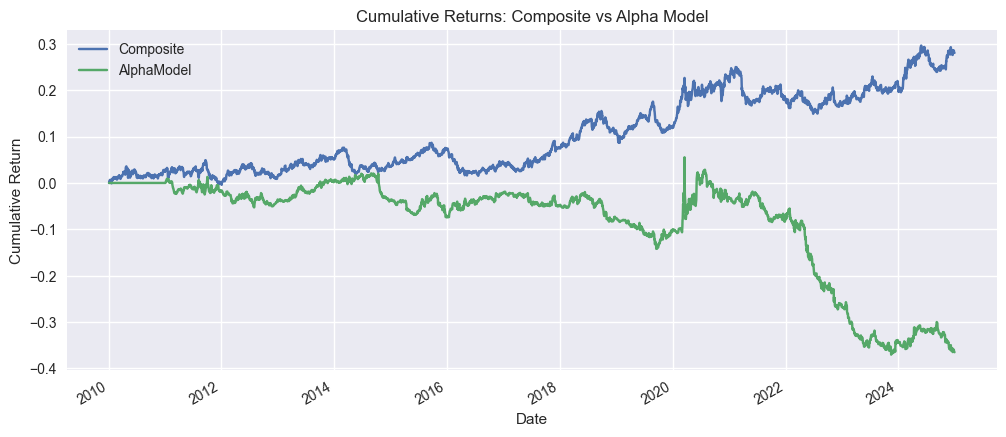

In [25]:
plt.figure(figsize=(12, 5))
pd.concat([pnl_comp, pnl_alpha], axis=1).plot(ax=plt.gca())
plt.title('Cumulative Returns: Composite vs Alpha Model')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

## 16. Drawdown analysis

Drawdowns highlight the depth and duration of losses from prior peaks.
We compute and plot drawdown series for both portfolios.

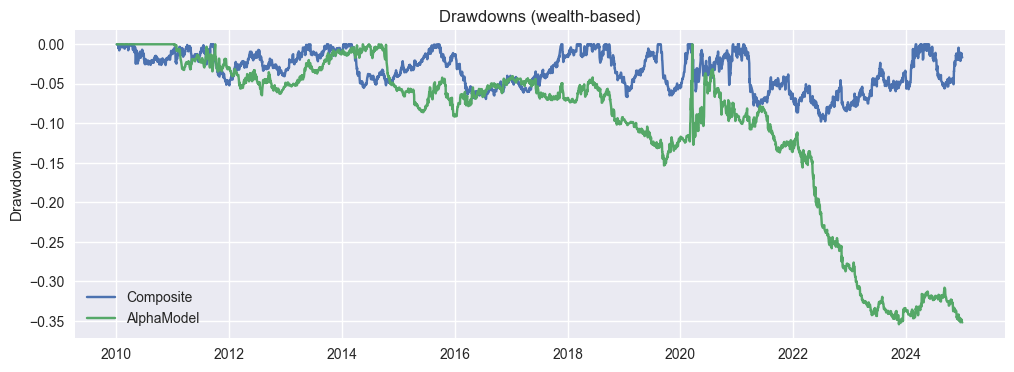

In [26]:
def compute_wealth(returns: pd.Series, initial_nav: float = 1.0) -> pd.Series:
    """
    Turn a series of simple returns into a wealth index.

    wealth_t = initial_nav * Π_{s≤t} (1 + r_s)
    """
    return (1.0 + returns).fillna(0.0).cumprod() * initial_nav


# Build wealth indices for both portfolios
wealth_comp = compute_wealth(returns_comp)
wealth_alpha = compute_wealth(returns_alpha)


def drawdown_from_wealth(wealth: pd.Series) -> pd.Series:
    """
    Standard drawdown definition based on a wealth index.

    DD_t = wealth_t / max_{s≤t} wealth_s - 1
    """
    peak = wealth.cummax()
    return wealth / peak - 1.0


dd_comp = drawdown_from_wealth(wealth_comp)
dd_alpha = drawdown_from_wealth(wealth_alpha)

plt.figure(figsize=(12, 4))
plt.plot(dd_comp, label="Composite")
plt.plot(dd_alpha, label="AlphaModel")
plt.title("Drawdowns (wealth-based)")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()

## 17. Summary statistics

We compute simple performance statistics for each portfolio:

- **Sharpe ratio** (annualized) using daily returns.
- **Average daily** turnover.
- **Maximum drawdown**, now computed from the wealth index built from cumulative returns.
- **Total cumulative** return as the final wealth minus 1.

This gives a compact, comparable summary of both strategies.

In [27]:
def sharpe(returns: pd.Series, freq: int = 252) -> float:
    if returns.std() == 0:
        return np.nan
    return (returns.mean() / returns.std()) * np.sqrt(freq)


summary = pd.DataFrame(
    {
        "Sharpe": [sharpe(returns_comp), sharpe(returns_alpha)],
        "AvgTurnover": [
            results_comp["turnover"].mean(),
            results_alpha["turnover"].mean(),
        ],
        "MaxDrawdown": [dd_comp.min(), dd_alpha.min()],
        # Final wealth minus 1.0 gives total simple return
        "TotalReturn": [wealth_comp.iloc[-1] - 1.0, wealth_alpha.iloc[-1] - 1.0],
    },
    index=["Composite", "AlphaModel"],
)

summary

,Sharpe,AvgTurnover,MaxDrawdown,TotalReturn
Composite,0.381936,0.345052,-0.097685,0.300020
AlphaModel,-0.438378,0.550032,-0.354104,-0.321654


## 18. Transaction-cost-aware performance

So far, our backtests reported **gross** performance, ignoring transaction
costs. Any daily-rebalanced long–short equity strategy will incur non-trivial
costs due to turnover and bid–ask spreads.

The `Backtester` implements a simple proportional cost model:

- Daily **turnover** is defined as the one-way notional traded,

  $$
  \text{turnover}_t = \sum_i \bigl| w_{t,i} - w_{t-1,i} \bigr|.
  $$

- We apply a cost of $\text{cost\_rate} \times \text{turnover}_t$, where

  $$
  \text{cost\_rate} = \frac{\text{transaction\_cost\_bps}}{10{,}000}.
  $$

- Net daily return is

  $$
  r^{\text{net}}_t = r^{\text{gross}}_t - \text{cost\_rate} \cdot \text{turnover}_t.
  $$

Below we compare gross vs net performance for the composite signal and the
Ridge-based alpha model using a cost of `COST_BPS` basis points per unit of
one-way turnover.

In [28]:
# 18.1 Run cost-aware backtests for composite and alpha portfolios

# Gross backtests (no costs)
results_comp_gross = backtester.run(prices, composite_signal_mkt_sec)
results_alpha_gross = backtester.run(prices, alpha_signal_mkt_sec)

# Cost-aware backtests
results_comp_cost = backtester_costly.run(prices, composite_signal_mkt_sec)
results_alpha_cost = backtester_costly.run(prices, alpha_signal_mkt_sec)

# Extract returns and turnover
ret_comp_gross = results_comp_gross["returns_gross"]
ret_alpha_gross = results_alpha_gross["returns_gross"]

ret_comp_net = results_comp_cost["returns"]
ret_alpha_net = results_alpha_cost["returns"]

turn_comp = results_comp_cost["turnover"]
turn_alpha = results_alpha_cost["turnover"]

ret_comp_gross.tail(), ret_comp_net.tail(), ret_alpha_gross.tail(), ret_alpha_net.tail()

(Date
 2024-12-23    0.000205
 2024-12-24    0.004322
 2024-12-26   -0.000846
 2024-12-27   -0.003690
 2024-12-30   -0.001003
 Name: returns_gross, dtype: float64,
 Date
 2024-12-23   -0.000085
 2024-12-24    0.004065
 2024-12-26   -0.001162
 2024-12-27   -0.003955
 2024-12-30   -0.001254
 Name: returns, dtype: float64,
 Date
 2024-12-23   -0.000509
 2024-12-24    0.003939
 2024-12-26   -0.001307
 2024-12-27   -0.003730
 2024-12-30   -0.000978
 Name: returns_gross, dtype: float64,
 Date
 2024-12-23   -0.000816
 2024-12-24    0.003705
 2024-12-26   -0.001562
 2024-12-27   -0.004033
 2024-12-30   -0.001978
 Name: returns, dtype: float64)

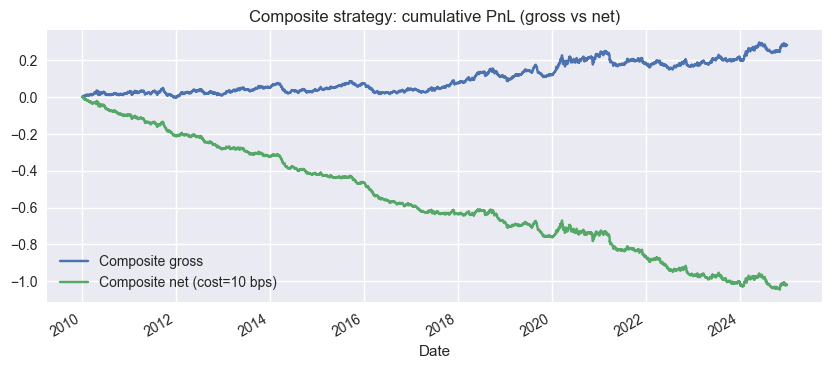

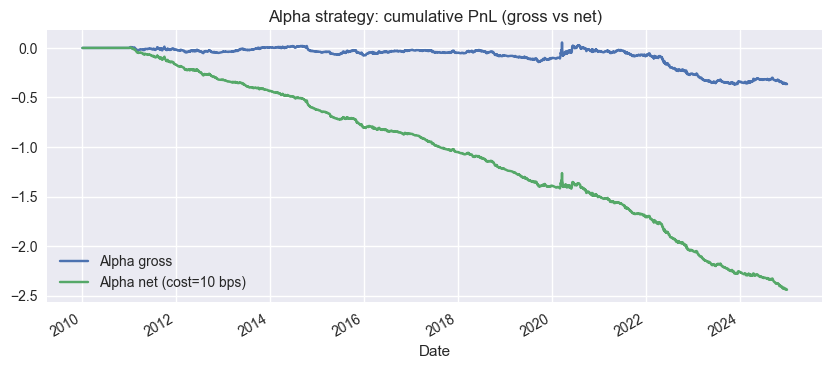

In [29]:
# 18.2 Plot cumulative PnL: gross vs net

pnl_comp_gross = ret_comp_gross.cumsum()
pnl_comp_net = ret_comp_net.cumsum()

pnl_alpha_gross = ret_alpha_gross.cumsum()
pnl_alpha_net = ret_alpha_net.cumsum()

pnl_comp_gross.name = "Composite_gross"
pnl_comp_net.name = "Composite_net"
pnl_alpha_gross.name = "Alpha_gross"
pnl_alpha_net.name = "Alpha_net"

# Composite portfolio
ax = pnl_comp_gross.plot(figsize=(10, 4), label="Composite gross")
pnl_comp_net.plot(ax=ax, label=f"Composite net (cost={COST_BPS:.0f} bps)")
ax.set_title("Composite strategy: cumulative PnL (gross vs net)")
ax.legend()
plt.show()

# Alpha portfolio
ax = pnl_alpha_gross.plot(figsize=(10, 4), label="Alpha gross")
pnl_alpha_net.plot(ax=ax, label=f"Alpha net (cost={COST_BPS:.0f} bps)")
ax.set_title("Alpha strategy: cumulative PnL (gross vs net)")
ax.legend()
plt.show()

In [30]:
# 18.3 Summary statistics: gross vs net, including turnover and cost drag

def summarize_with_cost(ret_gross: pd.Series,
                        ret_net: pd.Series,
                        turnover: pd.Series,
                        label: str) -> pd.Series:
    """
    Build a one-row summary for a strategy, comparing gross vs net returns.

    Assumes daily returns. Uses 252 trading days per year.
    """
    # Align indices
    idx = ret_gross.index.intersection(ret_net.index).intersection(turnover.index)
    rg = ret_gross.loc[idx]
    rn = ret_net.loc[idx]
    to = turnover.loc[idx]

    ann_factor = np.sqrt(252.0)

    sharpe_gross = rg.mean() / (rg.std(ddof=0) + 1e-12) * ann_factor
    sharpe_net = rn.mean() / (rn.std(ddof=0) + 1e-12) * ann_factor

    total_ret_gross = rg.sum()
    total_ret_net = rn.sum()

    avg_turnover = to.mean()
    avg_cost_per_day = (COST_BPS / 10000.0) * avg_turnover

    return pd.Series(
        {
            "Sharpe_gross": sharpe_gross,
            "Sharpe_net": sharpe_net,
            "TotalReturn_gross": total_ret_gross,
            "TotalReturn_net": total_ret_net,
            "AvgTurnover": avg_turnover,
            "AvgDailyCost": avg_cost_per_day,
        },
        name=label,
    )


summary_comp = summarize_with_cost(
    ret_comp_gross, ret_comp_net, turn_comp, label="Composite"
)
summary_alpha = summarize_with_cost(
    ret_alpha_gross, ret_alpha_net, turn_alpha, label="AlphaModel"
)

summary_tc = pd.DataFrame([summary_comp, summary_alpha])
summary_tc

,Sharpe_gross,Sharpe_net,TotalReturn_gross,TotalReturn_net,AvgTurnover,AvgDailyCost
Composite,0.381987,-1.387066,0.280402,-1.021478,0.345052,0.000345
AlphaModel,-0.438436,-2.905661,-0.364905,-2.440175,0.550032,0.000550


## 19. Information coefficient (IC) diagnostics for the alpha model

The information coefficient (IC) is the cross-sectional correlation between factor (or model) predictions and subsequent realized returns. Here we look at daily IC for the regression-based alpha model and compute:

- The time series of daily IC values.
- The mean IC.
- The t-statistic of the IC series.

This is a common diagnostic in quantitative equity research.

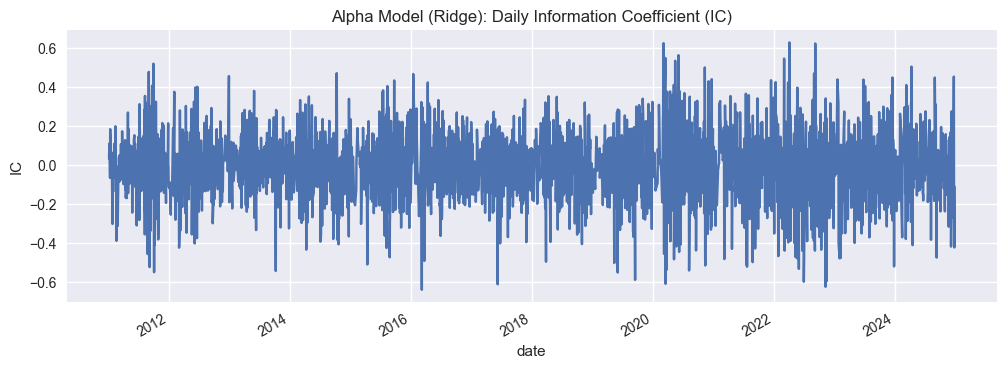

,MeanIC,ICtStat
0,-0.006776,-2.23143


In [31]:
# Extract IC series from the Ridge model results
ic_series = alpha_results_ridge["ic"]

# Handle DataFrame vs Series depending on model
if isinstance(ic_series, pd.DataFrame):
    ic = ic_series["ic"].dropna()
else:
    ic = ic_series.dropna()

plt.figure(figsize=(12, 4))
ic.plot(title='Alpha Model (Ridge): Daily Information Coefficient (IC)')
plt.ylabel('IC')
plt.grid(True)
plt.show()

mean_ic = ic.mean()
std_ic = ic.std()

ic_tstat = mean_ic / std_ic * np.sqrt(len(ic)) if std_ic > 0 else np.nan

pd.DataFrame({"MeanIC": [mean_ic], "ICtStat": [ic_tstat]})

### Interpreting the Information Coefficient (IC)

With our rolling out-of-sample (OOS) alpha model, the IC now reflects
genuine predictive power rather than in-sample overfitting.
Daily IC values typically fluctuate around zero with significant noise,
and only robust factor signals produce a persistent positive mean IC
over long periods.

Our current simple factor set and relatively simple model architecture
produce an average IC close to zero, which is realistic in the absence
of a full risk model, sector or style neutralization at the model level,
and more advanced regularization or nonlinear effects.

In professional quant workflows, an average IC of 0.02–0.05 is
considered strong for daily models, and achieving this usually requires
careful factor engineering and risk control.

## 20. OLS vs Ridge: Information Coefficient Comparison

To understand the impact of regularization, we compare the daily
Information Coefficient (IC) of both models.

The IC measures the cross-sectional correlation between predicted and
realized 1-day forward returns. Even small improvements in mean IC
(0.01–0.02) compound meaningfully in long-short portfolios.

We evaluate:

- Daily IC time series (noisy by nature)  
- Cumulative IC, which highlights directional drift over years  
- Mean and standard deviation of IC  

In practice, regularization is often used to stabilize IC and reduce noise.
In many mature production models, Ridge can produce smoother and more
persistent positive IC than raw OLS.

In this simple baseline setup, both OLS and Ridge yield IC values that
are close to zero with slight negative drift, which is realistic given
the limited factor set and absence of a full risk model. The goal here
is to illustrate the workflow rather than to optimize IC.

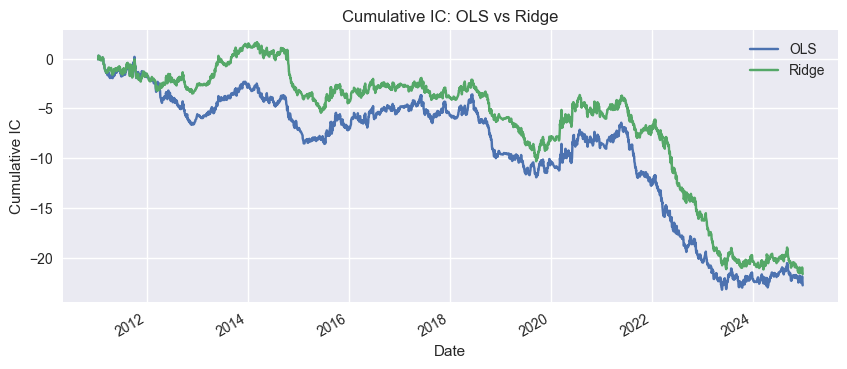

(OLS     -0.007225
 Ridge   -0.006867
 dtype: float64,
 OLS      0.16596
 Ridge    0.17066
 dtype: float64)

In [32]:
ic_ols = alpha_results_ols["ic"] # Series, index = date

# Ridge IC is stored as a DataFrame; extract the 'ic' column as a Series
ic_ridge_df = alpha_results_ridge["ic"]   # DataFrame with column 'ic'
if isinstance(ic_ridge_df, pd.DataFrame):
    ic_ridge = ic_ridge_df["ic"]
else:
    ic_ridge = ic_ridge_df

# Align on common dates
ic_compare = pd.DataFrame({
    "OLS": ic_ols,
    "Ridge": ic_ridge,
}).dropna(how="any")

ic_compare.cumsum().plot(figsize=(10, 4))
plt.title("Cumulative IC: OLS vs Ridge")
plt.xlabel("Date")
plt.ylabel("Cumulative IC")
plt.show()

ic_compare.mean(), ic_compare.std()

## 21. Portfolio optimization with risk control

### 21.1 From alpha forecasts to optimized portfolio weights

The earlier backtests used heuristic portfolio construction rules. Here we
convert expected returns into weights using a constrained mean–variance
optimizer.

Inputs per day:

- expected returns \\(\\mu_{t,i}\\) from the Ridge out-of-sample alpha model, and
- a rolling covariance estimate from historical daily returns.

Constraints and regularizers:

- target gross leverage,
- dollar-neutrality,
- per-asset box constraints,
- quadratic risk aversion, and
- a turnover penalty to discourage unnecessary trading.


In [33]:
# 21.1 Build expected-return panel and run the optimizer

mu_source = None
if "alpha_predictions_ridge" in globals():
    mu_source = alpha_predictions_ridge
elif "alpha_predictions" in globals():
    mu_source = alpha_predictions
else:
    raise NameError("Alpha predictions not found. Expected `alpha_predictions` or `alpha_predictions_ridge`.")

# Expected returns μ_{t,i}: MultiIndex (date, ticker) Series
mu_panel = mu_source.copy().rename("mu")
mu_panel.index.set_names(["date", "ticker"], inplace=True)

# Daily returns for covariance estimation (wide: date x ticker)
returns_for_cov = prices.pct_change().sort_index()

# Optimizer configuration
opt_cfg = OptimizerConfig(
    target_gross_leverage=1.0,
    max_weight=0.05,
    risk_aversion=5.0,
    turnover_penalty=1.0,
    enforce_dollar_neutral=True,
)

optimizer = PortfolioOptimizer(opt_cfg)

# Rolling optimization
weights_opt = optimizer.optimize_time_series(
    exp_ret_panel=mu_panel,
    returns=returns_for_cov,
    cov_lookback_days=60,
    min_cov_days=40,
)

weights_opt.name = "w"
weights_opt.head()

date        ticker
2011-01-04  A         0.000002
            ABT       0.050003
            ACGL      0.000002
            ACN       0.000002
            ADBE      0.000001
Name: w, dtype: float64

### 21.1a Sanity Checks on Optimized Weights

Before evaluating performance, we verify that the optimizer is behaving as intended.

Specifically, we check that:

- Gross exposure is consistently equal to the target leverage  
- Net exposure is close to zero on each date  
- Individual weights respect the specified box constraints  

These diagnostics confirm that the optimization constraints are enforced correctly and that the resulting portfolio is well-behaved.

In [34]:
# 21.1a Sanity checks

gross = weights_opt.abs().groupby(level="date").sum()
net = weights_opt.groupby(level="date").sum()
mx = weights_opt.abs().groupby(level="date").max()

pd.DataFrame(
    {
        "gross_mean": [gross.mean()],
        "gross_min": [gross.min()],
        "gross_max": [gross.max()],
        "net_abs_mean": [net.abs().mean()],
        "maxw_mean": [mx.mean()],
        "maxw_max": [mx.max()],
    }
)

,gross_mean,gross_min,gross_max,net_abs_mean,maxw_mean,maxw_max
0,1.0,1.0,1.0,0.000004,0.05,0.050003


### 21.1b Effective Sparsity of the Optimized Portfolio

Although the optimizer considers the full investment universe each day, in practice it allocates non-zero weight to only a subset of stocks.

We measure the average number of stocks receiving non-zero weight and the fraction of the universe actively traded on each day. This provides insight into the effective sparsity of the portfolio and helps interpret downstream performance and turnover.

A sparse solution is desirable, as it reflects confidence in stronger signals and reduces unnecessary exposure to noise.

In [35]:
# 21.1b Thresholded expected returns and re-optimize

Q = 0.10       # tail fraction kept on each side (10% top + 10% bottom)
MIN_NAMES = 20 # require at least this many nonzero μ names per day

mu_raw = mu_panel.copy()
mu_raw.name = "mu"
mu_raw.index.set_names(["date", "ticker"], inplace=True)

def threshold_mu_daily(mu_s: pd.Series, q: float) -> pd.Series:
    """
    For each date:
      - keep only bottom q and top q of μ values,
      - set the rest to 0.
    """
    def _th(g: pd.Series) -> pd.Series:
        g = g.astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if len(g) < 10:
            # too few names to define tails sensibly
            return pd.Series(0.0, index=g.index)

        lo = g.quantile(q)
        hi = g.quantile(1.0 - q)

        out = pd.Series(0.0, index=g.index)
        keep = (g <= lo) | (g >= hi)
        out.loc[keep] = g.loc[keep]
        return out

    return mu_s.groupby(level="date", group_keys=False).apply(_th)

mu_thresh = threshold_mu_daily(mu_raw, q=Q)
mu_thresh.name = "mu"
mu_thresh.index.set_names(["date", "ticker"], inplace=True)

# Filter dates with enough nonzero names
nonzero_counts = (mu_thresh != 0.0).groupby(level="date").sum()
valid_dates = nonzero_counts[nonzero_counts >= MIN_NAMES].index

mu_thresh = mu_thresh.loc[(valid_dates, slice(None))].rename("mu")
mu_thresh.index.set_names(["date", "ticker"], inplace=True)

# Re-optimize
weights_opt_th = optimizer.optimize_time_series(
    exp_ret_panel=mu_thresh,
    returns=returns_for_cov,
    cov_lookback_days=60,
    min_cov_days=40,
)

weights_opt_th.name = "w"
weights_opt_th.head()

date        ticker
2011-01-04  A         0.000002
            ABT       0.050003
            ACGL      0.000002
            ACN       0.000002
            ADBE      0.000001
Name: w, dtype: float64

### 21.1c Thresholding diagnostics

Thresholding and shrinkage are practical defenses against optimizer overreaction to noisy expected returns. Here we shrink the predicted returns and set small-magnitude forecasts to zero, so the optimizer only trades when the model expresses a meaningful edge. This reduces sensitivity to estimation error, at the cost of a sparser portfolio (fewer active names on each date).

In [36]:
# 21.1c Thresholding diagnostics

avg_nonzero_mu = (mu_thresh != 0.0).groupby(level="date").sum().mean()
avg_total_names = mu_thresh.groupby(level="date").size().mean()
avg_frac_nonzero = avg_nonzero_mu / avg_total_names

pd.DataFrame(
    {
        "avg_nonzero_mu": [avg_nonzero_mu],
        "avg_total_names": [avg_total_names],
        "avg_frac_nonzero": [avg_frac_nonzero],
    }
)

,avg_nonzero_mu,avg_total_names,avg_frac_nonzero
0,94.754992,469.279873,0.201916


### 21.2 Performance of the Optimized Portfolio

Using the optimized daily weights, we compute portfolio returns by applying weights at time \( t \) to realized returns from \( t \) to \( t+1 \).

We compare the cumulative performance of:

- The composite factor strategy  
- The Ridge alpha-model strategy  
- The fully optimized portfolio  

Summary statistics such as Sharpe ratio, maximum drawdown, and total return are reported for the optimized strategy.

This comparison highlights the effect of explicit risk control and optimization relative to simpler portfolio construction methods.

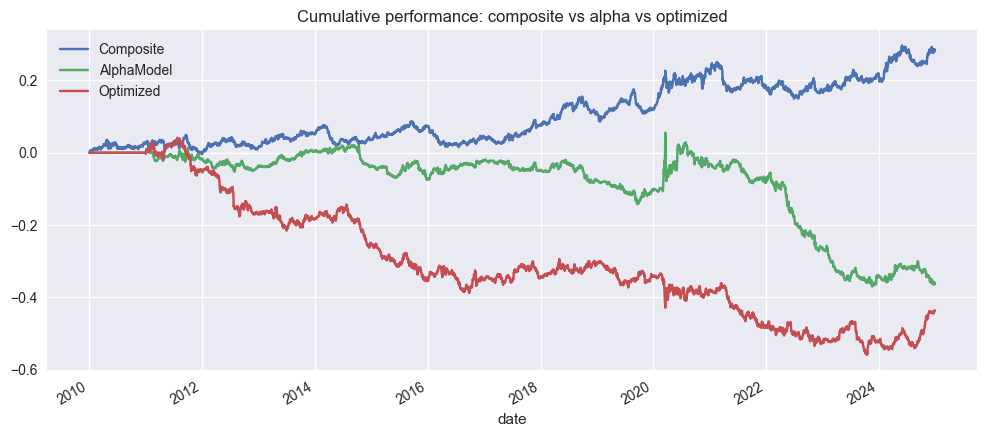

,Sharpe,MaxDrawdown,TotalReturn
Optimized,-0.505016,-0.462967,-0.369442


In [37]:
# 21.2 Compute optimized strategy returns and compare

# Forward returns from t to t+1 (wide)
fwd_returns = returns_for_cov.shift(-1)

# Convert forward returns to long and ensure index names
fwd_long = fwd_returns.stack().rename("ret_fwd")
fwd_long.index.set_names(["date", "ticker"], inplace=True)

# Ensure weights index names
w_base = weights_opt.copy()
w_base.index.set_names(["date", "ticker"], inplace=True)

# Daily portfolio return = sum_i w_{t,i} * r_{t->t+1,i}
ret_opt = (w_base * fwd_long).groupby(level="date").sum().dropna()

# Wealth index and cumulative return
equity_opt = (1.0 + ret_opt).cumprod()
pnl_opt = ret_opt.cumsum()

pnl_opt.name = "Optimized"
ret_opt.name = "ret_opt"

comparison = pd.concat(
    [
        pnl_comp.reindex(pnl_opt.index),
        pnl_alpha.reindex(pnl_opt.index),
        pnl_opt,
    ],
    axis=1,
)

comparison.plot(figsize=(12, 5), title="Cumulative performance: composite vs alpha vs optimized")
plt.grid(True)
plt.show()

# Summary stats
sharpe_opt = sharpe(ret_opt)
dd_opt = (equity_opt / equity_opt.cummax() - 1.0).min()
total_ret_opt = equity_opt.iloc[-1] - 1.0

pd.DataFrame(
    {"Sharpe": [sharpe_opt], "MaxDrawdown": [dd_opt], "TotalReturn": [total_ret_opt]},
    index=["Optimized"],
)

### 21.2a Robustness check: thresholded expected returns

Optimizers can be sensitive to noise in the expected returns. As a simple
robustness check, we re-run the optimization after zeroing out the middle of
the cross-section and keeping only the strongest positive and negative
forecasts each day (top/bottom tails).

We compare the resulting portfolio to the baseline optimized portfolio using
both performance curves and weight-level diagnostics.


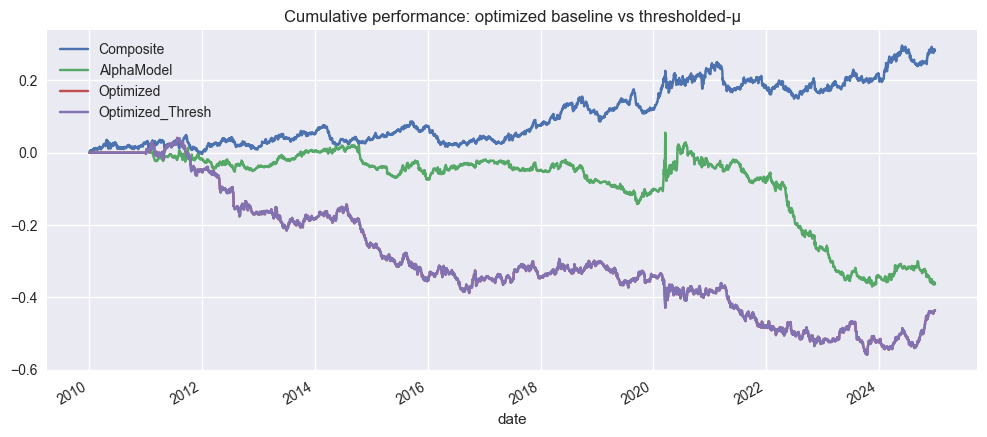

,Sharpe,MaxDrawdown,TotalReturn
Optimized_THRESH,-0.504934,-0.462922,-0.369381


In [38]:
# 21.2a Compute thresholded-μ optimized returns and compare

# Ensure weights index names
w_th = weights_opt_th.copy()
w_th.index.set_names(["date", "ticker"], inplace=True)

# Use same forward returns long series
ret_opt_th = (w_th * fwd_long).groupby(level="date").sum().dropna()

equity_opt_th = (1.0 + ret_opt_th).cumprod()
pnl_opt_th = ret_opt_th.cumsum()
pnl_opt_th.name = "Optimized_Thresh"

comparison_th = pd.concat(
    [
        pnl_comp.reindex(pnl_opt_th.index),
        pnl_alpha.reindex(pnl_opt_th.index),
        pnl_opt.reindex(pnl_opt_th.index),
        pnl_opt_th,
    ],
    axis=1,
)

comparison_th.plot(figsize=(12, 5), title="Cumulative performance: optimized baseline vs thresholded-μ")
plt.grid(True)
plt.show()

sharpe_opt_th = sharpe(ret_opt_th)
dd_opt_th = (equity_opt_th / equity_opt_th.cummax() - 1.0).min()
total_ret_opt_th = equity_opt_th.iloc[-1] - 1.0

pd.DataFrame(
    {"Sharpe": [sharpe_opt_th], "MaxDrawdown": [dd_opt_th], "TotalReturn": [total_ret_opt_th]},
    index=["Optimized_THRESH"],
)

## Next Steps

This framework can be extended by incorporating transaction cost models directly into the optimizer, adding industry or factor-based risk constraints, or exploring nonlinear and ensemble alpha models.

The current implementation already reflects a realistic end-to-end quantitative research pipeline suitable for professional quantitative research and portfolio construction workflows.